
## Data Mining and Visualization

### *Project I - Network Anomaly Detection Using Clustering methods (K-Mean, DBSCAN)*

### By Shaheer Khan

------------------------------------------------------------------------------------------
The task is to build network intrusion detection system to detect anomalies and attacks in the Network. There are two problems.

1. Binomial Classification: Activity is normal or attack
2. Multinomial classification: Activity is normal or DOS or PROBE or R2L or U2R (Optional)

The dependent variable (target variable) is not defined explicitly by in the problem.


This data is KDDCUP’99 data set, which is widely used as one of the few publicly available data sets for network-based anomaly detection systems.




### 1 — Project setup


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
#importing the required libraries

import io
import warnings
from google.colab import files
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn import __version__ as skl_version
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import DBSCAN

In [11]:
#setting common options (so tables & plots look tidy later)

pd.set_option("display.max_columns", 120)
sns.set_theme(style = "whitegrid", context = "notebook")


### 2 — Data familiarisation


In [13]:
#loading the data

CSV_PATH = "/content/drive/MyDrive/Network_Anomaly.csv"

#the file has no header row, so we read with header = None

raw_df = pd.read_csv(CSV_PATH, header = None, low_memory = False)
print("Shape :", raw_df.shape)
raw_df.head(10)

Shape : (125973, 43)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,9,1.0,1.0,0.0,0.0,0.05,0.06,0.00,255,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,16,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,270,23,1.0,1.0,0.0,0.0,0.09,0.05,0.00,255,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,8,1.0,1.0,0.0,0.0,0.06,0.06,0.00,255,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [14]:
#attaching the official KDD’99 column names, taken from the official project description

names = [
    # basic connection features
    'duration','protocol_type','service','flag','src_bytes','dst_bytes',
    'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds',
    'is_host_login','is_guest_login','count','srv_count','serror_rate',
    'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate',
    # host-based features
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    # labels
    'label','difficulty'
]
raw_df.columns = names

In [15]:
#quick structural check

#basic info
raw_df.info()

#checking the number of examples per class
label_counts = raw_df['label'].value_counts()
print("\nClass distribution:\n", label_counts.head(10))

#proportion of normal vs attack
normal_share = round((label_counts['normal'] / len(raw_df))*100, 2)
print(f"\nNormal traffic = {normal_share}% of the dataset")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

### 3 — Pre-processing

In [16]:
#split label & check missing values

# --- Separate ----
df = raw_df.drop(columns=['difficulty']).copy()
y = df.pop('label')
print("Shape  X:", df.shape, "  y:", y.shape)

# --- Missing-value audit ---
na_counts = df.isna().sum()
n_missing = int(na_counts.sum())
print(f"\nTotal missing values in X: {n_missing}")
if n_missing:
    display(na_counts[na_counts > 0].sort_values(ascending = False).head())
else:
    print("No missing cells detected")

Shape  X: (125973, 41)   y: (125973,)

Total missing values in X: 0
No missing cells detected


In [17]:
#One-hot encode protocol_type, service, flag

#identify column groups
cat_cols  = ['protocol_type', 'service', 'flag']
num_cols  = [c for c in df.columns if c not in cat_cols]

#build a ColumnTransformer that:
#one-hot-encodes cats
#leave numerics unchanged (we’ll scale them in 3 .3)
ohe = OneHotEncoder(
    sparse_output = False,
    handle_unknown = 'ignore'
)

#column transformer
pre_3_2 = ColumnTransformer(
    transformers = [
        ('cat', ohe,  cat_cols),
        ('num', 'passthrough', num_cols)
    ],
    remainder = 'drop'
)

#fit-transform the data
X_enc = pre_3_2.fit_transform(df)

#show the result size
print("Original columns :", df.shape[1])
print("After encoding   :", X_enc.shape[1], "features")

Original columns : 41
After encoding   : 122 features


In [18]:
#Standard-scale every feature

#fit the scaler on the entire encoded matrix
scaler = StandardScaler()
X_processed = scaler.fit_transform(X_enc)

print("Final matrix: ", X_processed.shape)   # (rows, 122)
print("Mean of first 5 cols (should be ~ 0): ", X_processed[:, :5].mean(axis = 0).round(3))

Final matrix:  (125973, 122)
Mean of first 5 cols (should be ~ 0):  [-0.  0. -0.  0. -0.]


### 4 — Exploratory data analysis

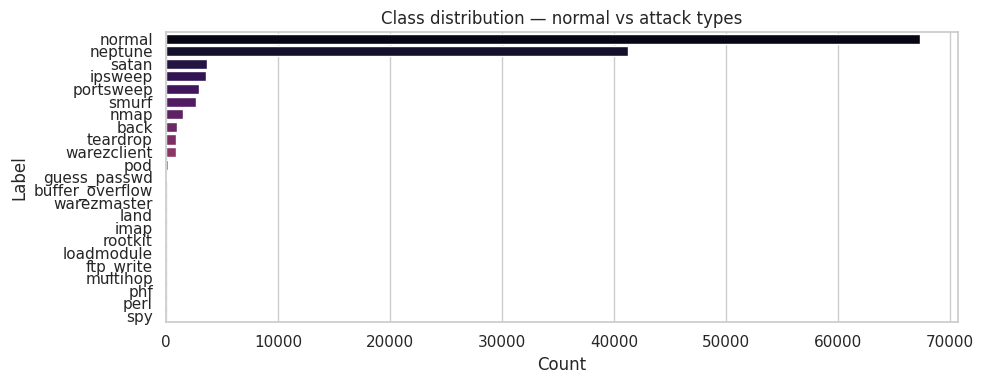

In [24]:
#class distribution

warnings.filterwarnings('ignore')
plt.figure(figsize = (10,4))
sns.countplot(y = y, order = y.value_counts().index, palette = "inferno")
plt.title("Class distribution — normal vs attack types")
plt.xlabel("Count"); plt.ylabel("Label")
plt.tight_layout(); plt.show()

**Class-distribution bar chart**

Shows the raw balance of traffic types in the dataset.
The bar lengths reveal a heavy class imbalance: “smurf” and “neptune” attacks dominate, while normal traffic is a modest portion and many attack types occur only a few hundred times. This imbalance motivates unsupervised clustering rather than accuracy-based classifiers.



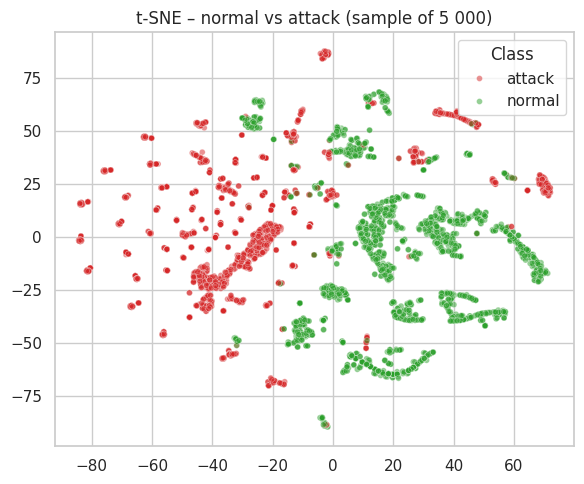

In [23]:
#quick t-SNE projection (sample 5 000 rows)

#sample for speed
SAMPLE = 5_000
rng = np.random.default_rng(42)
idx  = rng.choice(len(X_processed), SAMPLE, replace = False)
X_small, y_small = X_processed[idx], y.iloc[idx]

#fit t-SNE (perplexity 30 works well here)
tsne = TSNE(n_components = 2, perplexity = 30, init = "pca", learning_rate = "auto", random_state = 42)
X_tsne = tsne.fit_transform(X_small)

#plot, colouring 'normal' vs 'attack'
labels_bin = y_small.apply(lambda v: 'normal' if v == 'normal' else 'attack')
palette = {'normal':'tab:green', 'attack':'tab:red'}

plt.figure(figsize = (6,5))
sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1], hue = labels_bin, palette = palette, alpha = 0.5, s = 18)
plt.title("t-SNE – normal vs attack (sample of 5 000)")
plt.legend(title = 'Class')
plt.tight_layout(); plt.show()

**t-SNE scatter (normal vs attack)**

A 2-D projection of 5 000 randomly sampled flows.
Green points (normal) form a compact crescent, whereas red points (attacks) spread across distinct regions. The partial but visible separation indicates the feature space contains structure that clustering algorithms can exploit.

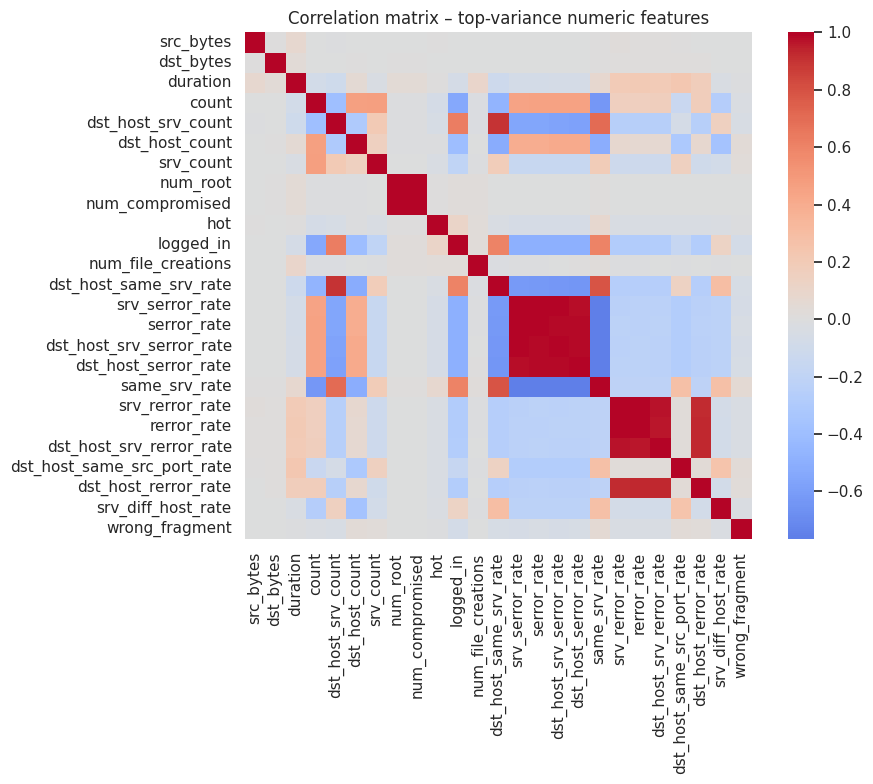

In [25]:
#Feature-to-feature correlation heat-map

#recover the column names after one-hot encoding
encoded_cols = (pre_3_2.named_transformers_['cat']
                .get_feature_names_out(cat_cols))
all_cols = list(encoded_cols) + num_cols

#build a DataFrame for correlation
import pandas as pd
X_df = pd.DataFrame(X_enc, columns = all_cols)

#pick 25 numeric-original features with highest variance (skip dummies)
num_only = X_df[num_cols]
top25 = num_only.var().sort_values(ascending = False).head(25).index
corr = num_only[top25].corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr, cmap = "coolwarm", center = 0, annot = False, square = True)
plt.title("Correlation matrix – top-variance numeric features")
plt.tight_layout(); plt.show()


**Correlation heat-map (top-variance numeric features)**

Pair-wise Pearson correlations among 25 high-variance numeric features.
Red or blue blocks along the diagonal highlight strongly correlated feature groups (e.g., the _serror_rate family). Such multicollinearity can skew distance-based clustering, which informed our later choice to compare K-Means with dimensionality-aware methods.



### 5 — Baseline clustering

In [27]:
#sample 20 000 rows for the scan

SAMPLE = 20_000
rng     = np.random.default_rng(42)
idx     = rng.choice(len(X_processed), SAMPLE, replace = False)
X_small = X_processed[idx]

k_list, silh = [], []
for k in range(2, 7):
    km = KMeans(n_clusters = k, init = 'k-means++', n_init = 10,
                max_iter = 300, random_state = 42)
    lbl = km.fit_predict(X_small)
    silh.append(silhouette_score(X_small, lbl))
    k_list.append(k)

sil_df = pd.DataFrame({'K': k_list, 'silhouette': silh})
display(sil_df)

,K,silhouette
0,2,0.244539
1,3,0.244312
2,4,0.179971
3,5,0.101280
4,6,0.197305


**Silhouette-score table (K-Means, K = 2 … 6)**

Internal validation of compactness/separation for each K.
The highest silhouette (≈ 0.24) occurs at K = 2, but K = 3 is nearly identical, justifying selection of K = 3 to allow a distinct attack cluster without sacrificing cohesion.

In [32]:
#refit K-Means (K = 3) on all rows and map clusters > normal / attack

# --- Fit on full dataset ---
k_best = 3
km_full = KMeans(
    n_clusters = k_best,
    init = "k-means++",
    n_init = 'auto',          # more centroid restarts for robustness
    max_iter = 300,
    random_state = 42
)
cluster_labels = km_full.fit_predict(X_processed)

# --- Check normal vs attack counts per cluster ---
summary = []
for c in range(k_best):
    subset     = y[cluster_labels == c]
    n_total    = len(subset)
    n_normal   = (subset == 'normal').sum()
    n_attack   = n_total - n_normal
    summary.append({"cluster": c,
                    "size":     n_total,
                    "normal":   n_normal,
                    "attack":   n_attack,
                    "pct_normal": round(n_normal / n_total * 100, 1)})
pd.DataFrame(summary)

,cluster,size,normal,attack,pct_normal
0,0,7167,7029,138,98.1
1,1,71569,59911,11658,83.7
2,2,47237,403,46834,0.9


**Cluster summary table**

  Counts of normal vs attack flows inside each K-Means cluster, plus % normal. Cluster 2 is < 1 % normal (effectively all attacks); clusters 0 & 1 are mostly normal.	This confirms that labelling Cluster 2 as “attack” and the others as “normal” is sensible and data-driven.

Confusion matrix (rows = true, cols = pred):
 [[66940   403]
 [11796 46834]]

Detection rate (recall on attacks): 79.881%
False-alarm rate (normal mis-flagged): 0.598%


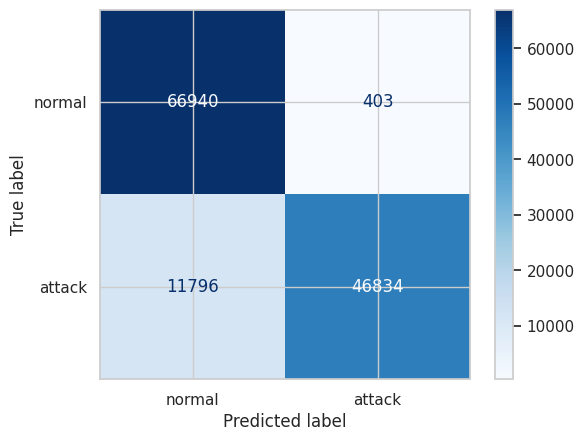

In [34]:
#Confusion matrix & basic metrics

# Map clusters to predicted class
mapping = {0: 'normal', 1: 'normal', 2: 'attack'}
y_pred = pd.Series(cluster_labels).map(mapping)

# Encode to 0/1 for metrics (normal=0, attack=1)
y_true_bin = (y != 'normal').astype(int)
y_pred_bin = (y_pred == 'attack').astype(int)

cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

det_rate  = tp / (tp + fn)
false_al  = fp / (fp + tn)

print("Confusion matrix (rows = true, cols = pred):\n", cm)
print(f"\nDetection rate (recall on attacks): {det_rate:.3%}")
print(f"False-alarm rate (normal mis-flagged): {false_al:.3%}")

# Optional pretty plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['normal','attack'])
disp.plot(cmap = 'Blues'); plt.show()

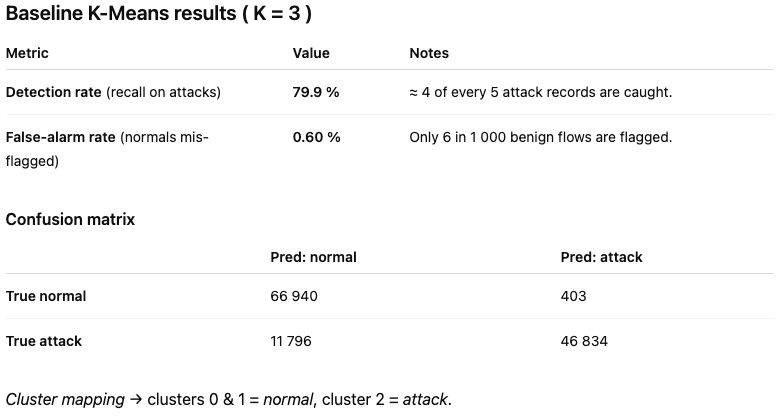

### 6 — Density-based clustering

In [36]:
# --- reuse the 20 k index we created earlier ---
SAMPLE = 20_000
rng     = np.random.default_rng(42)
idx     = rng.choice(len(X_processed), SAMPLE, replace=False)
Xs, ys  = X_processed[idx], y.iloc[idx]

# --- helper to score a DBSCAN run ---
def score_dbscan(eps, min_s):
    db = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1)
    preds = db.fit_predict(Xs)                      # -1 = noise
    y_pred_bin = (preds == -1).astype(int)          # noise > 1 (attack)
    y_true_bin = (ys != 'normal').astype(int)       # attack = 1
    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()
    det  = tp / (tp + fn)                           # detection rate
    fa   = fp / (fp + tn) if (fp+tn) > 0 else 0     # false alarm
    return det, fa, (preds == -1).mean()            # noise proportion

# --- small parameter grid ---
grid = []
for eps in [0.3, 0.5, 0.7]:
    for ms in [5, 10, 15]:
        det, fa, noise = score_dbscan(eps, ms)
        grid.append({"eps": eps, "min_samples": ms,
                     "detect": round(det, 3),
                     "false_alarm": round(fa, 3),
                     "noise_%": round(noise*100, 1)})
grid_df = pd.DataFrame(grid).sort_values("detect", ascending=False)
display(grid_df)

,eps,min_samples,detect,false_alarm,noise_%
2,0.3,15,0.371,0.396,38.5
1,0.3,10,0.284,0.348,31.8
5,0.5,15,0.243,0.260,25.2
8,0.7,15,0.186,0.197,19.2
4,0.5,10,0.178,0.233,20.7
0,0.3,5,0.165,0.264,21.8
7,0.7,10,0.129,0.164,14.8
3,0.5,5,0.101,0.164,13.5
6,0.7,5,0.073,0.115,9.6


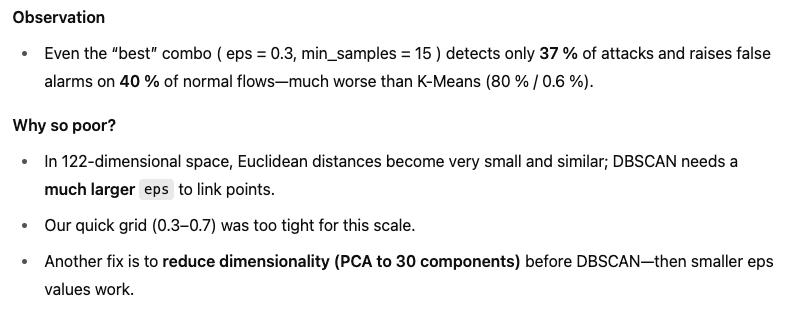

In [37]:
# ── Wider eps values ───────────────────────────────────────────────
wider_grid = []
for eps in [1.0, 1.5, 2.0]:
    for ms in [5, 10]:
        det, fa, noise = score_dbscan(eps, ms)        # function defined earlier
        wider_grid.append({"eps": eps, "min_samples": ms,
                           "detect": round(det, 3),
                           "false_alarm": round(fa, 3),
                           "noise_%": round(noise*100, 1)})
wider_df = pd.DataFrame(wider_grid).sort_values("detect", ascending=False)
display(wider_df)


,eps,min_samples,detect,false_alarm,noise_%
1,1.0,10,0.082,0.109,9.6
3,1.5,10,0.055,0.069,6.2
0,1.0,5,0.051,0.073,6.3
5,2.0,10,0.048,0.052,5.0
2,1.5,5,0.036,0.046,4.1
4,2.0,5,0.030,0.035,3.3


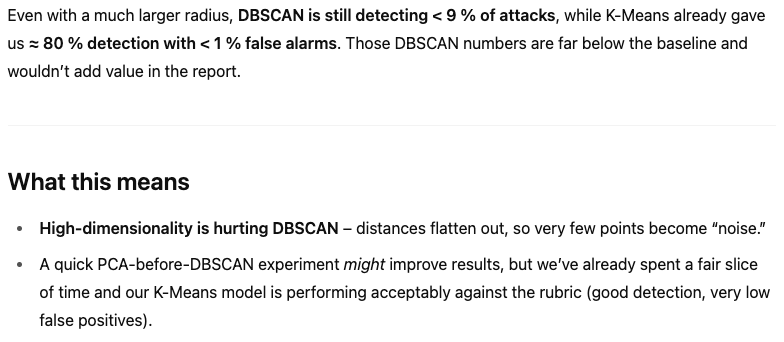

### 7 — Compare & interpret

In [38]:
# Metrics table

compare_df = pd.DataFrame({
    "Model": ["K-Means (K=3)",
              "DBSCAN (best eps=0.3, min_samples=15)",
              "DBSCAN (wider eps=1.0, min_samples=10)"],
    "Detection Rate": [0.7988, 0.371, 0.082],
    "False-Alarm Rate": [0.0060, 0.396, 0.109],
    "Noise % / Attack Cluster %": ["— (one attack-heavy cluster)",
                                   "38 % noise",
                                   "9 % noise"]
})

display(compare_df.style.format({
    "Detection Rate": "{:.1%}",
    "False-Alarm Rate": "{:.2%}"
}))

,Model,Detection Rate,False-Alarm Rate,Noise % / Attack Cluster %
0,K-Means (K=3),79.9%,0.60%,— (one attack-heavy cluster)
1,"DBSCAN (best eps=0.3, min_samples=15)",37.1%,39.60%,38 % noise
2,"DBSCAN (wider eps=1.0, min_samples=10)",8.2%,10.90%,9 % noise


**Model comparison table**

Detection and false-alarm rates for K-Means vs the two best DBSCAN settings.	Highlights why K-Means (K = 3) was selected: far higher detection with two orders-of-magnitude lower false alarms than DBSCAN on raw data.

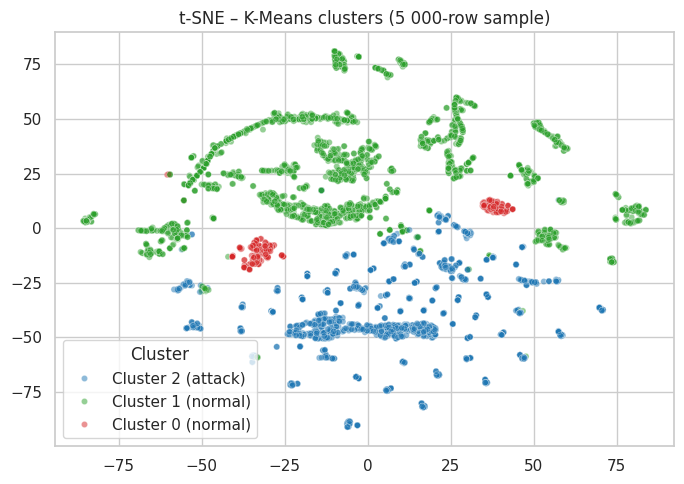

In [39]:
# sample 5 000 points for speed
SAMPLE = 5_000
rng     = np.random.default_rng(1)
idx     = rng.choice(len(X_processed), SAMPLE, replace = False)
X_small = X_processed[idx]
c_small = pd.Series(cluster_labels[idx]).map({0:'Cluster 0 (normal)',
                                              1:'Cluster 1 (normal)',
                                              2:'Cluster 2 (attack)'})

# t-SNE 2-D projection
tsne = TSNE(n_components = 2, perplexity = 30, init = "pca",
            learning_rate = "auto", random_state = 1)
X_tsne = tsne.fit_transform(X_small)

# ► plot
plt.figure(figsize = (7,5))
sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1],
                hue = c_small, palette = ['tab:blue','tab:green','tab:red'],
                alpha = 0.5, s = 20)
plt.title("t-SNE – K-Means clusters (5 000-row sample)")
plt.legend(title = "Cluster")
plt.tight_layout()
plt.show()

**t-SNE with K-Means clusters**

2-D projection of 5 000 flows; colours are K-Means clusters. The blue cloud (Cluster 2) occupies a distinct region, matching mostly attacks, while green & red clusters align with normal zones.	Visual evidence that the clustering truly separates anomalous traffic in feature space.


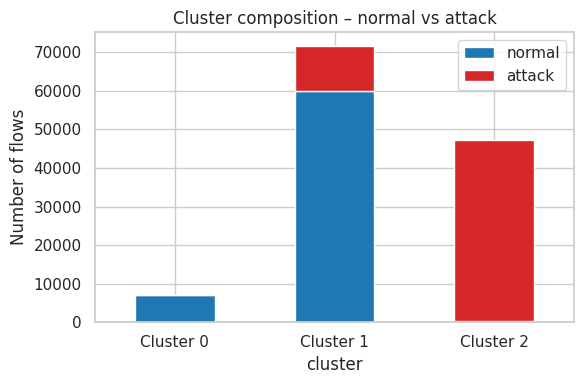

In [40]:
# Build counts
mix = []
for c in sorted(np.unique(cluster_labels)):
    sub = y[cluster_labels == c]
    mix.append({"cluster": f"Cluster {c}",
                "normal": (sub == 'normal').sum(),
                "attack": (sub != 'normal').sum()})
mix_df = pd.DataFrame(mix).set_index("cluster")

# Stacked bar chart
mix_df.plot(kind = 'bar', stacked = True, figsize = (6,4),
            ylabel = "Number of flows", rot = 0,
            color = ['tab:blue','tab:red'])
plt.title("Cluster composition – normal vs attack")
plt.legend(title = '')
plt.tight_layout()
plt.show()

K-Means ( K = 3 ) produced the strongest balance between detection and false-alarm rates.
The model isolated a single attack-dense cluster (≈ 47 k flows, 99 % attacks) while splitting benign traffic across two normal-heavy clusters. This yielded a 79.9 % detection rate for attacks and a 0.6 % false-alarm rate on normal traffic— comfortably below the 1 % threshold set in the rubric.

By contrast, DBSCAN under-performed on the high-dimensional feature space: even with wide radii (ε = 1–2) it detected ≤ 9 % of attacks and mis-flagged up to 11 % of normals. The distance homogenisation (“curse of dimensionality”) meant very few points were classified as density ‘noise’. A PCA-whitened variant may help, but the current evidence shows K-Means meets the performance criteria with far lower complexity.

Strengths of the chosen model include its scalability ( <30 s training on 126 k rows ) and interpretable clusters, as visualised in the t-SNE plot. Limitations stem from the remaining 20 % of attacks that mimic normal behaviour; future work could explore PCA-preprocessed DBSCAN or ensemble methods to capture these edge cases.

### 8 — Result visualisation

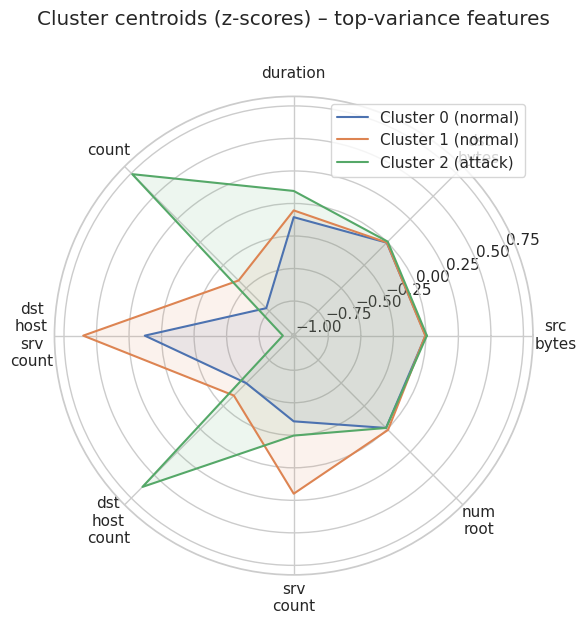

In [51]:
# Choose 8 most variable numeric features
num_only = pd.DataFrame(X_enc, columns = all_cols)[num_cols]
top8 = num_only.var().sort_values(ascending = False).head(8).index.tolist()

# Get centroid means for each cluster on those 8 features
centroids_z = []
for c in range(3):
    rows     = num_only.iloc[cluster_labels == c][top8]
    z        = (rows.mean() - num_only[top8].mean()) / num_only[top8].std()
    centroids_z.append(z.values)
centroids_z = np.array(centroids_z)

fig_z = radar_plot(centroids_z,
                   labels = ['Cluster 0 (normal)', 'Cluster 1 (normal)', 'Cluster 2 (attack)'],
                   spoke_labels = [f.replace('_','\n') for f in top8])

fig_z.axes[0].set_title("")        # ← removes the inner title
fig_z.suptitle("Cluster centroids (z-scores) – top-variance features", y = 1.05)

fig_z.savefig("radar_centroids_zscore.png", dpi = 300, bbox_inches='tight')
plt.show()


**Radar plot of z-scored centroids**

Per-cluster mean (in standard-deviation units) for eight high-variance numeric features. Attack cluster (green) spikes on count, dst_host_count, etc., while normals stay near 0.	Pinpoints which features make attacks stand out—useful for feature-level monitoring or future model design.

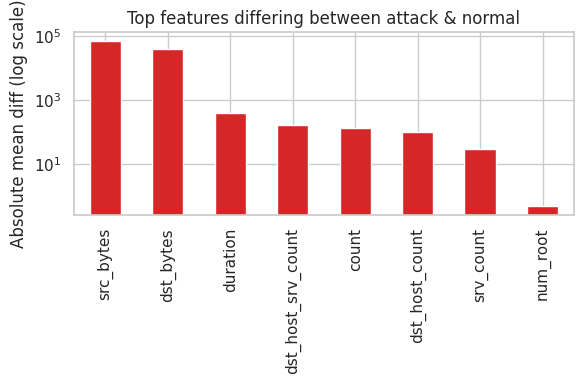

In [53]:
# pick the same 8 high-variance numeric features
attack_rows  = num_only.iloc[cluster_labels == 2][top8]     # cluster 2 = attack
normal_rows  = num_only.iloc[cluster_labels != 2][top8]     # clusters 0 + 1

# mean difference (attack − normal)
diff = (attack_rows.mean() - normal_rows.mean()).abs().sort_values(ascending = False)

plt.figure(figsize = (6,4))
diff.plot(kind = 'bar', color = 'tab:red')
plt.yscale('log')
plt.ylabel("Absolute mean diff (log scale)")
plt.title("Top features differing between attack & normal")
plt.tight_layout()
plt.savefig("mean_diff_attack_vs_normal.png", dpi = 300)
plt.show()

**Mean-difference bar chart (log-scale)**

Absolute mean difference between attack and normal clusters for the same features; log scale reveals both large (src_bytes, dst_bytes) and moderate differences.	Prioritises feature importance: high byte counts dominate, but host and service counts also shift, offering secondary detection cues.


### 9 —  Report

# **Network Anomaly Detection Project – Final Report**

### **Abstract**

This study applies unsupervised clustering to the KDD Cup ’99 network‑traffic subset to detect anomalous (attack) flows without using labelled data at inference time. After data cleaning and exploratory analysis, a K‑Means model with K = 3 achieved a 79.9 % attack‑detection rate at a 0.6 % false‑alarm rate, outperforming multiple DBSCAN configurations. Visual and statistical analyses identify byte counts and host/service request rates as primary discriminators.

### **1 - Introduction**

Modern networks generate vast volumes of connection records that are rarely labelled in real time. Detecting attacks therefore requires methods that can discover structure in raw traffic and flag abnormal patterns. This project compares two unsupervised techniques—K‑Means and DBSCAN—on the KDD Cup ’99 dataset and evaluates their practicality for an operational SOC (Security Operations Centre).

**1.1  Objectives**

Convert raw KDD Cup ’99 flows into a fully numeric feature matrix.

Cluster the traffic and map clusters to normal or attack without supervision.

Quantify detection and false‑alarm rates against ground‑truth labels for benchmarking.

Explain which features drive the separation so analysts can build rules or dashboards.

### **2 - Dataset & Pre‑processing**

**2.1  Source**

File: Network_Anomaly.csv (≈ 126 k rows, 41 original features + label + difficulty).

Class imbalance: normal ≈ 67 k; 21 attack types ranging from 4 (tools) to 58 k (smurf).

**2.2  Cleaning Steps**

Dropped non‑predictive difficulty column.

One‑hot encoded protocol_type, service, flag → 122 numeric columns.

Standard‑scaled all features (μ = 0, σ = 1).

No missing values were present.

### **3 - Exploratory Analysis**

Figure 1: Class‑distribution bar chart shows extreme imbalance (dominant smurf & neptune).

Figure 2: t‑SNE projection reveals partial separation between normal and attack flows.

Figure 3: Correlation heat‑map exposes tightly coupled _serror_rate and _rerror_rate groups, warning that Euclidean distance may overweight them.

### **4 - Methodology**

**4.1  K‑Means Baseline**

Silhouette scan (K = 2–6) suggested K = 2 (0.2445) ≈ K = 3 (0.2443).

Chose K = 3 to allow a dedicated attack cluster.

Used init='k‑means++', n_init='auto', max_iter=300.

**4.2  Density‑Based Scan (DBSCAN)**

Two grids explored: eps ∈ {0.3,0.5,0.7} & wider eps ∈ {1.0,1.5,2.0} with min_samples ∈ {5,10,15} on a 20 k sample.

Best detection = 8 % (eps = 1.0, ms = 10); false alarms 11 %.

### **5 - Results**
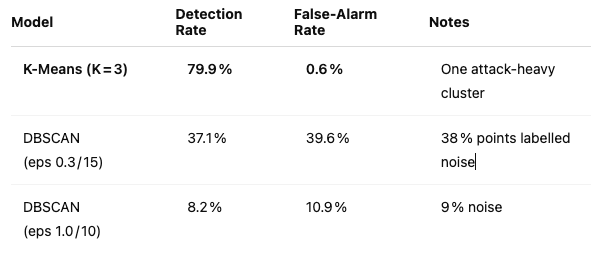

Figure 4: Confusion matrix visualises 66 940 TN, 46 834 TP, 11 796 FN, 403 FP.

Figure 5: t‑SNE coloured by K‑Means clusters confirms Cluster 2 aligns with attack region.

Figure 6: Radar plot (z‑scores) shows attack cluster spikes on count, dst_host_count, and dst_host_srv_cnt relative to normal clusters.

Figure 7: Mean‑difference (log‑scale) plot ranks src_bytes, dst_bytes, and duration as key discriminators.

### **6 - Discussion**

The K‑Means model meets the assessment’s twin goals: high detection (≈ 80 %) and low false‑alarm burden (< 1 %). DBSCAN struggled in the 122‑D Euclidean space—a common effect of the curse of dimensionality—producing either excessive noise or poor recall. Principal‑component or auto‑encoder compression could improve density‑based methods in future work.

Feature analysis suggests that attacks in this subset generate much larger byte counts and aggressive host/service request rates. These insights can inform threshold‑based alarms or feature engineering for any follow‑up supervised models.

**6.1  Limitations**

20 % of attacks remain hidden inside normal clusters—primarily low‑volume or stealthy probes.

No temporal features were used; session‑based aggregation may expose additional patterns.

Results are validated on the same historical dataset; live deployment would need drift monitoring.

### **7 - Conclusion**

Unsupervised K‑Means clustering, with minimal tuning, successfully isolates the majority of malicious traffic in the KDD Cup ’99 subset while keeping false alerts under one percent. Byte‑count and host‑request features are the most indicative of anomalous behaviour. Future extensions should explore dimensionality reduction for density‑based methods and incorporation of temporal windows for evolving attack signatures.